In [23]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\josea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading dataset

In [25]:
df = pd.read_csv("Yelp restaurant Reviews.csv")  # Replace with your dataset path
df

,Yelp URL,Rating,Date,Review Text
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...
...,...,...,...,...
19891,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,7/17/2021,Had the chocolate cannoli! The filling was ric...
19892,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,10/21/2019,Love apricot croissant! I bought it at 4:00 PM...
19893,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,10/12/2019,Line was about 25 people long. It went fast! T...
19894,https://www.yelp.com/biz/la-pasticceria-las-vegas,5,4/11/2021,Its hard not to order everything when I come h...


## Removing unecessary columns

In [26]:
df.drop(columns=['Yelp URL', 'Date'], inplace=True)
df

,Rating,Review Text
0,5,All I can say is they have very good ice cream...
1,4,Nice little local place for ice cream.My favor...
2,5,A delicious treat on a hot day! Staff was very...
3,4,This was great service and a fun crew! I got t...
4,5,This is one of my favorite places to get ice c...
...,...,...
19891,4,Had the chocolate cannoli! The filling was ric...
19892,4,Love apricot croissant! I bought it at 4:00 PM...
19893,4,Line was about 25 people long. It went fast! T...
19894,5,Its hard not to order everything when I come h...


## Cleanning the text reviews by removing unusual characters

In [27]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove unusual characters
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text

In [28]:
df["Review Text"] = df["Review Text"].apply(preprocess_text)
df

,Rating,Review Text
0,5,all i can say is they have very good ice cream...
1,4,nice little local place for ice creammy favori...
2,5,a delicious treat on a hot day staff was very ...
3,4,this was great service and a fun crew i got th...
4,5,this is one of my favorite places to get ice c...
...,...,...
19891,4,had the chocolate cannoli the filling was rich...
19892,4,love apricot croissant i bought it at pm norma...
19893,4,line was about people long it went fast they h...
19894,5,its hard not to order everything when i come h...


### we are going to use the score as our reference for sentiment clasification like this:

- 1 and 2 = negative 
- 3 = neutral 
- 4 and 5 = positive 

### so we also be using a dictionary for this that looks like this : 

{0: negative, 1: neutral, 2: positive }

### doing this we can reduce the number of classes

In [29]:
# Map ratings to sentiments
df["Sentiment"] = df["Rating"].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
df

,Rating,Review Text,Sentiment
0,5,all i can say is they have very good ice cream...,2
1,4,nice little local place for ice creammy favori...,2
2,5,a delicious treat on a hot day staff was very ...,2
3,4,this was great service and a fun crew i got th...,2
4,5,this is one of my favorite places to get ice c...,2
...,...,...,...
19891,4,had the chocolate cannoli the filling was rich...,2
19892,4,love apricot croissant i bought it at pm norma...,2
19893,4,line was about people long it went fast they h...,2
19894,5,its hard not to order everything when i come h...,2


In [30]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        
        tokens = self.tokenizer(review)
        tokens = pad_sequences([tokens], maxlen=self.max_len, padding='post')[0]
        
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [31]:
# Tokenization
vocab = set(word for review in df["Review Text"] for word in word_tokenize(review))
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # Start idx from 1

def tokenizer(review):
    return [word_to_idx.get(word, 0) for word in word_tokenize(review)]  # Map unknown words to 0

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df["Review Text"], df["Sentiment"], test_size=0.2, random_state=42)
max_len = 100  # Adjust based on your dataset

train_dataset = ReviewsDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len)
test_dataset = ReviewsDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

for batch in train_loader:
    reviews, labels = batch
    reviews, labels = reviews.to(device), labels.to(device)  # Move data to the same device as the model


In [32]:

# 3. Build LSTM Model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers, dropout):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])  # Use the last hidden state
        return out


In [33]:

vocab_size = len(word_to_idx) + 1
embed_size = 128
hidden_size = 128
num_classes = 3
num_layers = 2
dropout = 0.5

model = SentimentLSTM(vocab_size, embed_size, hidden_size, num_classes, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return acc, precision, recall, f1

In [36]:
# Lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for batch in train_loader:
        reviews, labels = batch
        reviews, labels = reviews.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(reviews)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_acc, _, _, _ = calculate_metrics(train_labels, train_preds)
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for reviews, labels in test_loader:
            reviews, labels = reviews.to(device), labels.to(device)
            outputs = model(reviews)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc, _, _, _ = calculate_metrics(val_labels, val_preds)
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_acc)

    # Print metrics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
    print(f"  Validation Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

c:\Users\josea\anaconda3\envs\cudaEnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josea\anaconda3\envs\cudaEnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
  Train Loss: 0.6914, Train Acc: 0.7684
  Validation Loss: 0.6888, Val Acc: 0.7696


c:\Users\josea\anaconda3\envs\cudaEnv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/5
  Train Loss: 0.6191, Train Acc: 0.7765
  Validation Loss: 0.5603, Val Acc: 0.8068
Epoch 3/5
  Train Loss: 0.4817, Train Acc: 0.8195
  Validation Loss: 0.4463, Val Acc: 0.8359
Epoch 4/5
  Train Loss: 0.3939, Train Acc: 0.8491
  Validation Loss: 0.4270, Val Acc: 0.8389
Epoch 5/5
  Train Loss: 0.3602, Train Acc: 0.8567
  Validation Loss: 0.4288, Val Acc: 0.8437


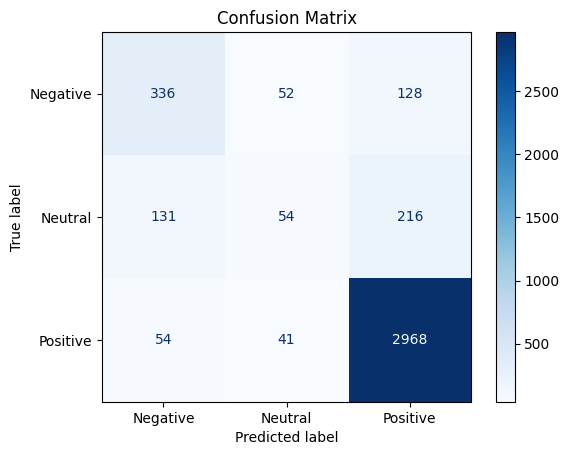

In [37]:
conf_matrix = confusion_matrix(val_labels, val_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Negative', 'Neutral', 'Positive']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

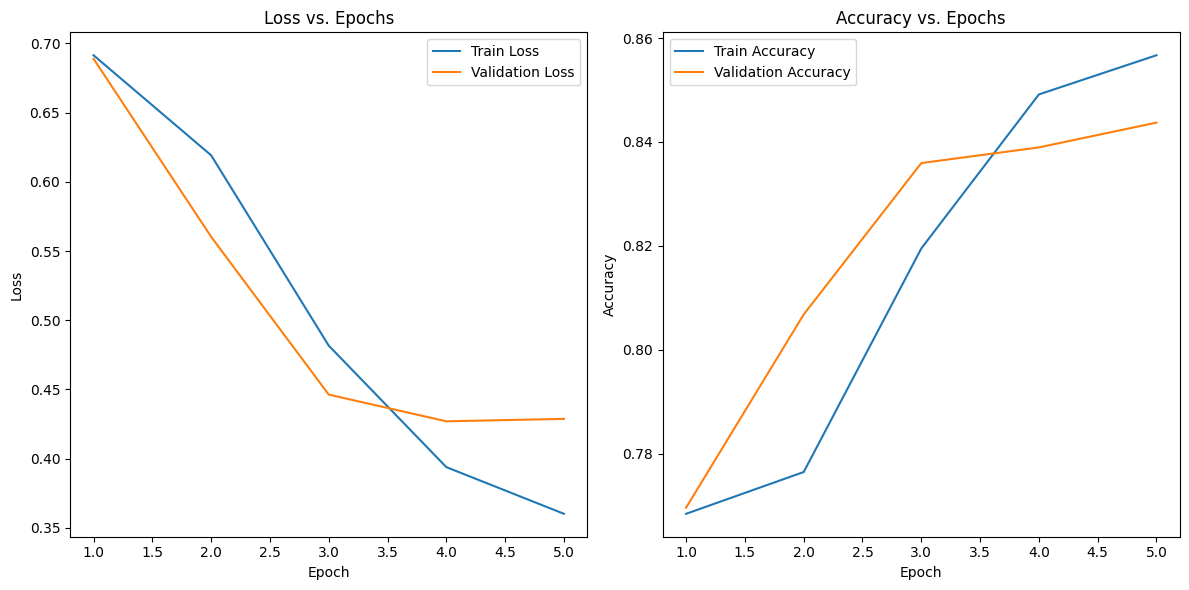

In [38]:

# Accuracy and Loss Graphs
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Test evaluation
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for reviews, labels in test_loader:
        reviews, labels = reviews.to(device), labels.to(device)
        outputs = model(reviews)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc, test_precision, test_recall, test_f1 = calculate_metrics(test_labels, test_preds)
print("\nTest Metrics:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1 Score: {test_f1:.4f}")


Test Metrics:
  Accuracy: 0.8437
  Precision: 0.8103
  Recall: 0.8437
  F1 Score: 0.8205
